In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import shapely
import random
import os

from shapely.geometry import shape
from shapely.geometry import Point

import pystac_client
import planetary_computer as pc

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* THIS NEEDS TO BE DYNAMIC, NOT HARDCODED *********
# ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
# we only need the image at this point to access the datasets crs

In [3]:
fp = os.path.join(os.getcwd(),'aux_data','campuspoint2018polys/campuspoint2018polys.shp')
polys = gpd.read_file(fp)
polys.head()

polys['iceplant'] = polys.id.apply(lambda x : 1 if x<10 else 0) 
polys.drop('id',axis=1,inplace=True)
polys.to_crs(ds.crs,inplace=True)
polys

,geometry,iceplant
0,"POLYGON ((238347.176 3810851.075, 238350.922 3...",1
1,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1
2,"POLYGON ((238527.281 3810831.411, 238531.339 3...",1
3,"POLYGON ((238513.547 3810846.706, 238512.610 3...",1
4,"POLYGON ((238419.905 3810816.740, 238438.945 3...",1
5,"POLYGON ((239087.262 3811796.777, 239089.759 3...",1
6,"POLYGON ((239498.195 3812050.546, 239512.397 3...",1
7,"POLYGON ((239470.102 3812026.823, 239478.686 3...",1
8,"POLYGON ((239974.833 3812163.541, 239974.209 3...",1
9,"POLYGON ((238375.113 3810886.737, 238379.482 3...",0


In [4]:
polys['area'] = polys.geometry.apply(lambda p : p.area)
polys.sort_values(by='area',ascending=False,inplace=True)
polys.reset_index(drop=True,inplace=True)
polys.head()

,geometry,iceplant,area
0,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1,925.592242
1,"POLYGON ((238593.923 3811127.708, 238612.964 3...",0,918.966999
2,"POLYGON ((238667.901 3811241.951, 238688.814 3...",0,850.911637
3,"POLYGON ((239249.107 3811881.522, 239285.627 3...",0,787.289556
4,"POLYGON ((238564.270 3811247.257, 238588.617 3...",0,740.278963


<AxesSubplot:>

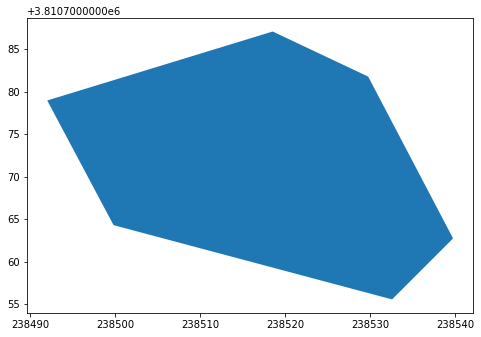

In [5]:
# pick biggest polygon
biggest = polys.filter(items=[0],axis=0).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)

In [6]:
def random_pts_poly(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  

<AxesSubplot:>

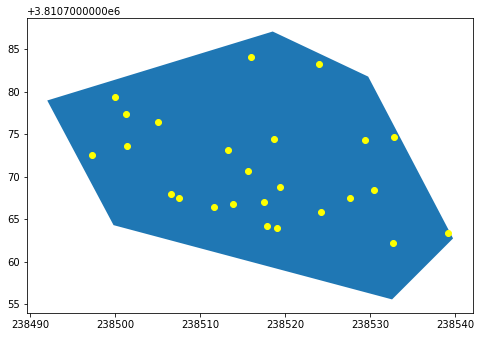

In [7]:
N=25  
# DEFINE NUMBER OF RANDOM POINTS TO BE SELECTED ON BIGGEST POLYGON
# the rest of the polygons will have a number of polygons proportional to their area

points = random_pts_poly(N,biggest['geometry'][0])
# ********** SIMPLIFY THIS ***************
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points
geo_points.set_crs(polys.crs,inplace=True)
# *******************************************************************

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)
geo_points.plot(ax=ax,color='yellow')

In [8]:
big_area = biggest['geometry'][0].area
polys['num_random_pts'] = polys.area.apply(lambda a : int(a/big_area*N))
polys.drop('area',axis=1,inplace=True)
polys

,geometry,iceplant,num_random_pts
0,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1,25
1,"POLYGON ((238593.923 3811127.708, 238612.964 3...",0,24
2,"POLYGON ((238667.901 3811241.951, 238688.814 3...",0,22
3,"POLYGON ((239249.107 3811881.522, 239285.627 3...",0,21
4,"POLYGON ((238564.270 3811247.257, 238588.617 3...",0,19
5,"POLYGON ((239545.016 3812095.025, 239571.860 3...",0,16
6,"POLYGON ((238375.113 3810886.737, 238379.482 3...",0,14
7,"POLYGON ((238513.547 3810846.706, 238512.610 3...",1,13
8,"POLYGON ((239498.195 3812050.546, 239512.397 3...",1,13
9,"POLYGON ((238730.016 3811157.986, 238745.311 3...",0,12


In [9]:
samples = []
for i in range(0,polys.shape[0]):
    poly = polys['geometry'][i]
    N = polys['num_random_pts'][i]
    
    points = random_pts_poly(N,poly)
    sample = pd.DataFrame({
        'geometry': pd.Series(points), 
        'iceplant':pd.Series(np.full(N,polys['iceplant'][i]))
                 })
    sample['xy']=sample.geometry.apply(lambda p :(p.x, p.y))
    
    data_generator = ds.sample(sample.xy)
    data = []
    for i in data_generator:
        data.append(i)
    data = np.vstack(data)
    data = pd.DataFrame(data, columns=['r','g','b','nifr'])
    
    sample = pd.concat([sample,data],axis=1)
    samples.append(sample)


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interfac

In [10]:
train_set = pd.concat(samples)
train_set['x']= train_set.geometry.apply(lambda p : p.x)
train_set['y']= train_set.geometry.apply(lambda p : p.y)
train_set.drop('xy',axis=1,inplace=True)
train_set.reset_index(drop=True,inplace=True)
train_set

,geometry,iceplant,r,g,b,nifr,x,y
0,POINT (238534.77144037225 3810764.4391108337),1,89,84,89,144,238534.771440,3.810764e+06
1,POINT (238516.67475820333 3810768.371394962),1,100,88,93,148,238516.674758,3.810768e+06
2,POINT (238496.0413784355 3810771.828721741),1,97,93,96,140,238496.041378,3.810772e+06
3,POINT (238497.93042821612 3810771.2369597284),1,87,80,86,137,238497.930428,3.810771e+06
4,POINT (238522.77706395302 3810778.261675573),1,82,75,80,158,238522.777064,3.810778e+06
...,...,...,...,...,...,...,...,...
219,POINT (238435.885596731 3810813.8951357515),1,87,81,85,159,238435.885597,3.810814e+06
220,POINT (238336.84159943755 3810851.862739198),1,90,83,92,131,238336.841599,3.810852e+06
221,POINT (238340.22229547755 3810855.007647482),1,84,81,88,133,238340.222295,3.810855e+06
222,POINT (239084.64065072205 3811791.015848144),1,107,97,94,157,239084.640651,3.811791e+06


In [11]:
train_set = train_set[['geometry','x','y','r','g','b','nifr','iceplant']]
train_set

,geometry,x,y,r,g,b,nifr,iceplant
0,POINT (238534.77144037225 3810764.4391108337),238534.771440,3.810764e+06,89,84,89,144,1
1,POINT (238516.67475820333 3810768.371394962),238516.674758,3.810768e+06,100,88,93,148,1
2,POINT (238496.0413784355 3810771.828721741),238496.041378,3.810772e+06,97,93,96,140,1
3,POINT (238497.93042821612 3810771.2369597284),238497.930428,3.810771e+06,87,80,86,137,1
4,POINT (238522.77706395302 3810778.261675573),238522.777064,3.810778e+06,82,75,80,158,1
...,...,...,...,...,...,...,...,...
219,POINT (238435.885596731 3810813.8951357515),238435.885597,3.810814e+06,87,81,85,159,1
220,POINT (238336.84159943755 3810851.862739198),238336.841599,3.810852e+06,90,83,92,131,1
221,POINT (238340.22229547755 3810855.007647482),238340.222295,3.810855e+06,84,81,88,133,1
222,POINT (239084.64065072205 3811791.015848144),239084.640651,3.811791e+06,107,97,94,157,1


In [12]:
type(train_set)

pandas.core.frame.DataFrame

In [13]:
train_fp = os.path.join(os.getcwd(),'aux_data','trainset.csv')
train_set.to_csv(train_fp)

In [14]:
os.getcwd()

'/home/jovyan/msai4earth-esa/iceplant_detection/training_set'